In [47]:
import numpy as np
import struct
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import ConfusionMatrixDisplay

with open('train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)

In [3]:
# Note sklearn.PCA take features as columns, hence we have to take the transpose of X_train and X_test
X_train = np.transpose(Xtraindata)
X_test = np.transpose(Xtestdata)
pca = PCA(svd_solver='full')
pca.fit(X_train)

PCA(svd_solver='full')

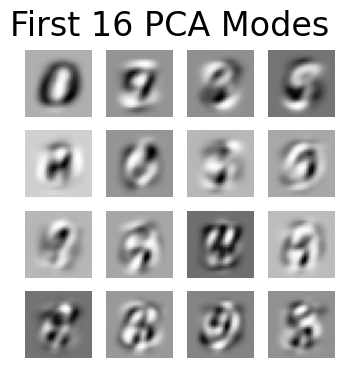

In [4]:
# Graph the first 16 PC modes
fig1, ax1 = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        ax1[i,j].imshow(pca.components_[(4)*i+j,:].reshape((28, 28)), cmap="Greys")
        ax1[i,j].axis("off")
fig1.suptitle('First 16 PCA Modes ', fontsize=24)
fig1.savefig('figure1.pdf', bbox_inches='tight')

In [5]:
# Find the amount of PC modes needed to reach the approximation by certain percentage
def find_modes(E, target):
    percentage = 0
    for i in range(len(E)):
        percentage += E[i]
        if percentage >= target:
            return i+1, percentage

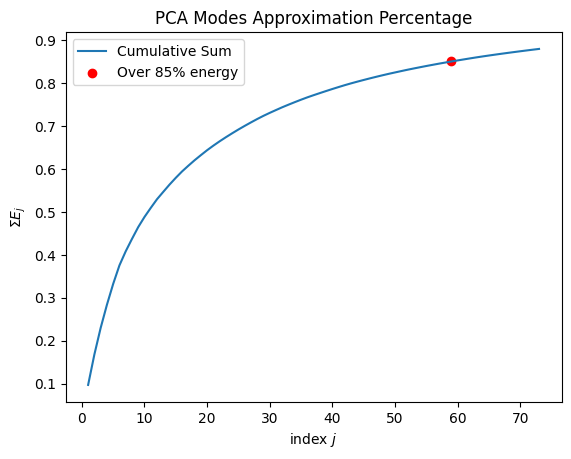

In [6]:
# Compute the cumulative Energy and graph
E = np.power(pca.singular_values_, 2)/np.sum(np.power(pca.singular_values_, 2))
pca_85, percentage_85 = find_modes(E, 0.85)
fig2 = plt.figure(2)
ax2 = plt.axes()
ax2.plot(np.arange(1, pca_85+15), np.cumsum(E)[:pca_85+14], label = 'Cumulative Sum')
ax2.scatter(pca_85, percentage_85, c = 'r', label = 'Over 85% energy')
ax2.legend()
plt.xlabel('index $j$')
plt.ylabel('$\Sigma E_j$')
plt.title('PCA Modes Approximation Percentage')
fig2.savefig('figure2.pdf', bbox_inches='tight')

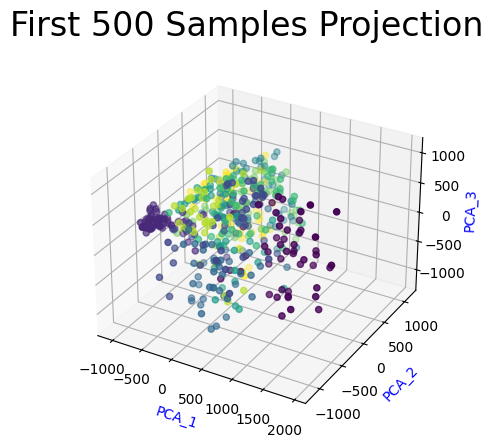

In [34]:
# Graph the first 500 sample projection on 3-PC modes space
n = 500
pca_64 = PCA(n_components=3, svd_solver='full')
pca_64.fit(X_train)
X_approx = pca_64.transform(X_train[:n, :])
fig3 = plt.figure(3)
ax3 = plt.axes(projection='3d')
ax3.scatter(X_approx[:,0], X_approx[:,1], X_approx[:,2], c=ytrainlabels[:n])
ax3.set_xlabel('PCA_1', fontsize=10, labelpad = 4, color = 'blue')
ax3.set_ylabel('PCA_2', fontsize=10, labelpad = 4, color = 'blue')
ax3.set_zlabel('PCA_3', fontsize=10, labelpad = 2, color = 'blue')
fig3.suptitle('First 500 Samples Projection', fontsize=24)
fig3.savefig('figure3.pdf', bbox_inches='tight')

In [7]:
# Find the subsets for train and test data set
def create_sub(digits, X_train, y_train, X_test, y_test):
    # Finding the indices of the targets
    indices_train_1 = np.where(y_train == digits[0])[0]
    indices_train_2 = np.where(y_train == digits[1])[0]
    indices_test_1 = np.where(y_test == digits[0])[0]
    indices_test_2 = np.where(y_test == digits[1])[0]

    # Create X_subtrain and y_subtrain
    X_subtrain = X_train[indices_train_1,:]
    X_subtrain = np.concatenate((X_subtrain, X_train[indices_train_2,:]), axis = 0)
    y_subtrain = np.ones(indices_train_1.shape[0]+indices_train_2.shape[0])
    y_subtrain[:indices_train_1.shape[0]] = digits[0]
    y_subtrain[:indices_train_2.shape[0]] = digits[1]

    # Create X_subtest and y_subtest
    X_subtest = X_test[indices_test_1,:]
    X_subtest = np.concatenate((X_subtest, X_test[indices_test_2,:]), axis = 0)
    y_subtest = np.ones(indices_test_1.shape[0]+indices_test_2.shape[0])
    y_subtest[:indices_test_1.shape[0]] = digits[0]
    y_subtest[:indices_test_2.shape[0]] = digits[1]
    return X_subtrain, y_subtrain, X_subtest, y_subtest

In [8]:
# Perform Ridge Classification
def transform_ridge(X_train, y_train, X_test, y_test, pca):
    # Project subset data onto 59 PCA modes space
    X_approx_train = pca.transform(X_train)
    X_approx_test = pca.transform(X_test)
    # Apply Ridge Classifier
    RidgeCL = RidgeClassifierCV()
    RidgeCL.fit(X_approx_train, y_train)
    print("Training Score: {}".format(RidgeCL.score(X_approx_train, y_train)))
    print("Testing Score: {}".format(RidgeCL.score(X_approx_test, y_test)))
    scores = cross_val_score(RidgeCL, X_approx_train, y_train, cv=5)
    print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

For digits: [1, 8]


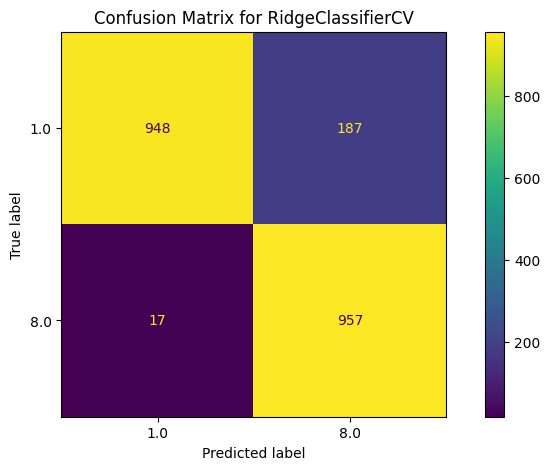

In [38]:
pca_59 = PCA(n_components=59, svd_solver='full')
pca_59.fit(X_train)

# Select subsets for [1,8] digits and perform Ridge Classification
digits_1 = [1, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = create_sub(digits_1, X_train, ytrainlabels, X_test, ytestlabels)
print("For digits:", digits_1)
X_approx_subtrain = pca.transform(X_subtrain)
X_approx_subtest = pca.transform(X_subtest)
# Apply Ridge Classifier
RidgeCL = RidgeClassifierCV()
RidgeCL.fit(X_approx_train, y_subtrain)
y_pred = RidgeCL.predict(X_approx_subtest)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_subtest, y_pred, ax=ax)
_ = ax.set_title(
    f"Confusion Matrix for {RidgeCL.__class__.__name__}"
)

In [40]:
pca_59 = PCA(n_components=59, svd_solver='full')
pca_59.fit(X_train)

# Select subsets for [1,8] digits and perform Ridge Classification
digits_1 = [1, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = create_sub(digits_1, X_train, ytrainlabels, X_test, ytestlabels)
print("For digits:", digits_1)
transform_ridge(X_subtrain, y_subtrain, X_subtest, y_subtest, pca_59)

# Select subsets for [3,8] digits and perform Ridge Classification
digits_2 = [3, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = create_sub(digits_2, X_train, ytrainlabels, X_test, ytestlabels)
print("For digits:", digits_2)
transform_ridge(X_subtrain, y_subtrain, X_subtest, y_subtest, pca_59)

# Select subsets for [2,7] digits and perform Ridge Classification
digits_3 = [2, 7]
X_subtrain, y_subtrain, X_subtest, y_subtest = create_sub(digits_3, X_train, ytrainlabels, X_test, ytestlabels)
print("For digits:", digits_3)
transform_ridge(X_subtrain, y_subtrain, X_subtest, y_subtest, pca_59)

For digits: [1, 8]
Training Score: 0.9041531009290876
Testing Score: 0.905642484589853
0.9020996266342438 accuracy with a standard deviation of 0.13449693735086216
For digits: [3, 8]
Training Score: 0.9379068602904357
Testing Score: 0.9440524193548387
0.936572008834081 accuracy with a standard deviation of 0.005517736655549978
For digits: [2, 7]
Training Score: 0.9563118710627505
Testing Score: 0.9733009708737864
0.9554882705946536 accuracy with a standard deviation of 0.04682175065103189


In [41]:
# We will perform classifications on all the digits with different algorithms
X_approx_train = pca.transform(X_train)
X_approx_test = pca.transform(X_test)

# Ridge Classifier
transform_ridge(X_train, ytrainlabels, X_test, ytestlabels, pca_59)

Training Score: 0.8453666666666667
Testing Score: 0.8561
0.8440666666666667 accuracy with a standard deviation of 0.009791776595127585


In [42]:
# KNN Classifier
KNNCL = KNeighborsClassifier(n_neighbors=3)
KNNCL.fit(X_approx_train, ytrainlabels)
print("Training Score: {}".format(KNNCL.score(X_approx_train, ytrainlabels)))
print("Testing Score: {}".format(KNNCL.score(X_approx_test, ytestlabels)))
k_values = [i for i in range (1,5)]
scores_knn = []
for k in k_values:
    KNNCLk = KNeighborsClassifier(n_neighbors=k)
    scorescv = cross_val_score(KNNCLk, X_approx_train, ytrainlabels,cv=5)
    print("{} accuracy with a standard deviation of {}".format(scorescv.mean(), scorescv.std()))
    scores_knn.append(scorescv.mean())

Training Score: 0.9867166666666667
Testing Score: 0.9705
0.9694 accuracy with a standard deviation of 0.0008586164581594042
0.96315 accuracy with a standard deviation of 0.0009723968097209633
0.9700666666666666 accuracy with a standard deviation of 0.0011695203195232586
0.9685 accuracy with a standard deviation of 0.0010839741694339384


In [43]:
# LDA Classifier
LDACL = LinearDiscriminantAnalysis()
LDACL.fit(X_approx_train, ytrainlabels)
print("Training Score: {}".format(LDACL.score(X_approx_train, ytrainlabels)))
print("Testing Score: {}".format(LDACL.score(X_approx_test, ytestlabels)))

scores =  cross_val_score(LDACL, X_approx_train, ytrainlabels,cv=5)
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

Training Score: 0.8714833333333334
Testing Score: 0.8729
0.8629666666666667 accuracy with a standard deviation of 0.007346881424568303


In [48]:
# RandomForest Classifier
clf = RF(n_estimators = 1)
clf = clf.fit(X_approx_train, ytrainlabels)
print("Training Score: {}".format(clf.score(X_approx_train, ytrainlabels)))
print("Testing Score: {}".format(clf.score(X_approx_test, ytestlabels)))
estimators = [i for i in range (1,5)]
scores_rf = []
for k in estimators:
    start = time.time()
    clf = RF(n_estimators = k)
    clf = clf.fit(X_approx_train, ytrainlabels)
    scorescl = cross_val_score(clf, X_approx_train, ytrainlabels,cv=5)
    print("{} accuracy with a standard deviation of {}".format(scorescl.mean(), scorescl.std()))
    scores_rf.append(scorescl.mean())
    end = time.time()
    print("Used time: ", end - start)

Training Score: 0.8321
Testing Score: 0.5444
0.5152166666666667 accuracy with a standard deviation of 0.017690125933852368
Used time:  16.394450426101685
0.5401833333333335 accuracy with a standard deviation of 0.023500969247151397
Used time:  30.11890435218811
0.6092333333333333 accuracy with a standard deviation of 0.016459326974224826
Used time:  46.073237657547
0.6752333333333335 accuracy with a standard deviation of 0.014903523073421245
Used time:  60.4256865978241
